In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import hdbscan

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [4]:
df = pd.read_csv('/content/drive/MyDrive/VAYU - M /india_cms_final_master_enriched.csv')
print("Dataset loaded successfully!")


Dataset loaded successfully!


In [5]:
print("Dataset Head:")
print(df.head())
print(f"\nDataset Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)
print("\nDataset Info:")
df.info()
print("\nStatistical Summary:")
print(df.describe())


Dataset Head:
  species_scientific_name species_common_name taxonomic_group  \
0            Orcinus orca        Killer Whale        Mammalia   
1            Orcinus orca        Killer Whale        Mammalia   
2            Orcinus orca        Killer Whale        Mammalia   
3            Orcinus orca        Killer Whale        Mammalia   
4            Orcinus orca        Killer Whale        Mammalia   

               family   latitude  longitude country          state_province  \
0  Checklist Verified  12.758315  80.373937   India  Coastal India / Marine   
1  Checklist Verified  10.858728  72.210113   India  Coastal India / Marine   
2  Checklist Verified  15.000000  90.000000   India  Coastal India / Marine   
3  Checklist Verified  13.737500  80.265831   India  Coastal India / Marine   
4  Checklist Verified  15.355615  73.755595   India  Coastal India / Marine   

            event_date    year  month  data_source   observation_type  \
0  2023-02-24T17:21:58  2023.0    2.0         G

In [6]:
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after dropping duplicates: {df.shape}")

print("\nNULL Values:")
print(df.isnull().sum())

numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nZero values in numeric columns:")
for col in numeric_cols:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count} zeros")

df = df.dropna(subset=['species_scientific_name', 'migration_season'])
print(f"\nShape after cleaning: {df.shape}")

Original shape: (12374, 20)
Shape after dropping duplicates: (12374, 20)

NULL Values:
species_scientific_name        0
species_common_name            0
taxonomic_group                0
family                         0
latitude                       0
longitude                      0
country                        0
state_province                 0
event_date                   318
year                         117
month                        117
data_source                    0
observation_type               0
occurrence_id                  0
india_role                  2152
migration_season            2152
location_type               2152
seasonal_density            2152
priority_group             10767
iucn_red_list_status           0
dtype: int64

Zero values in numeric columns:
month: 9 zeros

Shape after cleaning: (10222, 20)


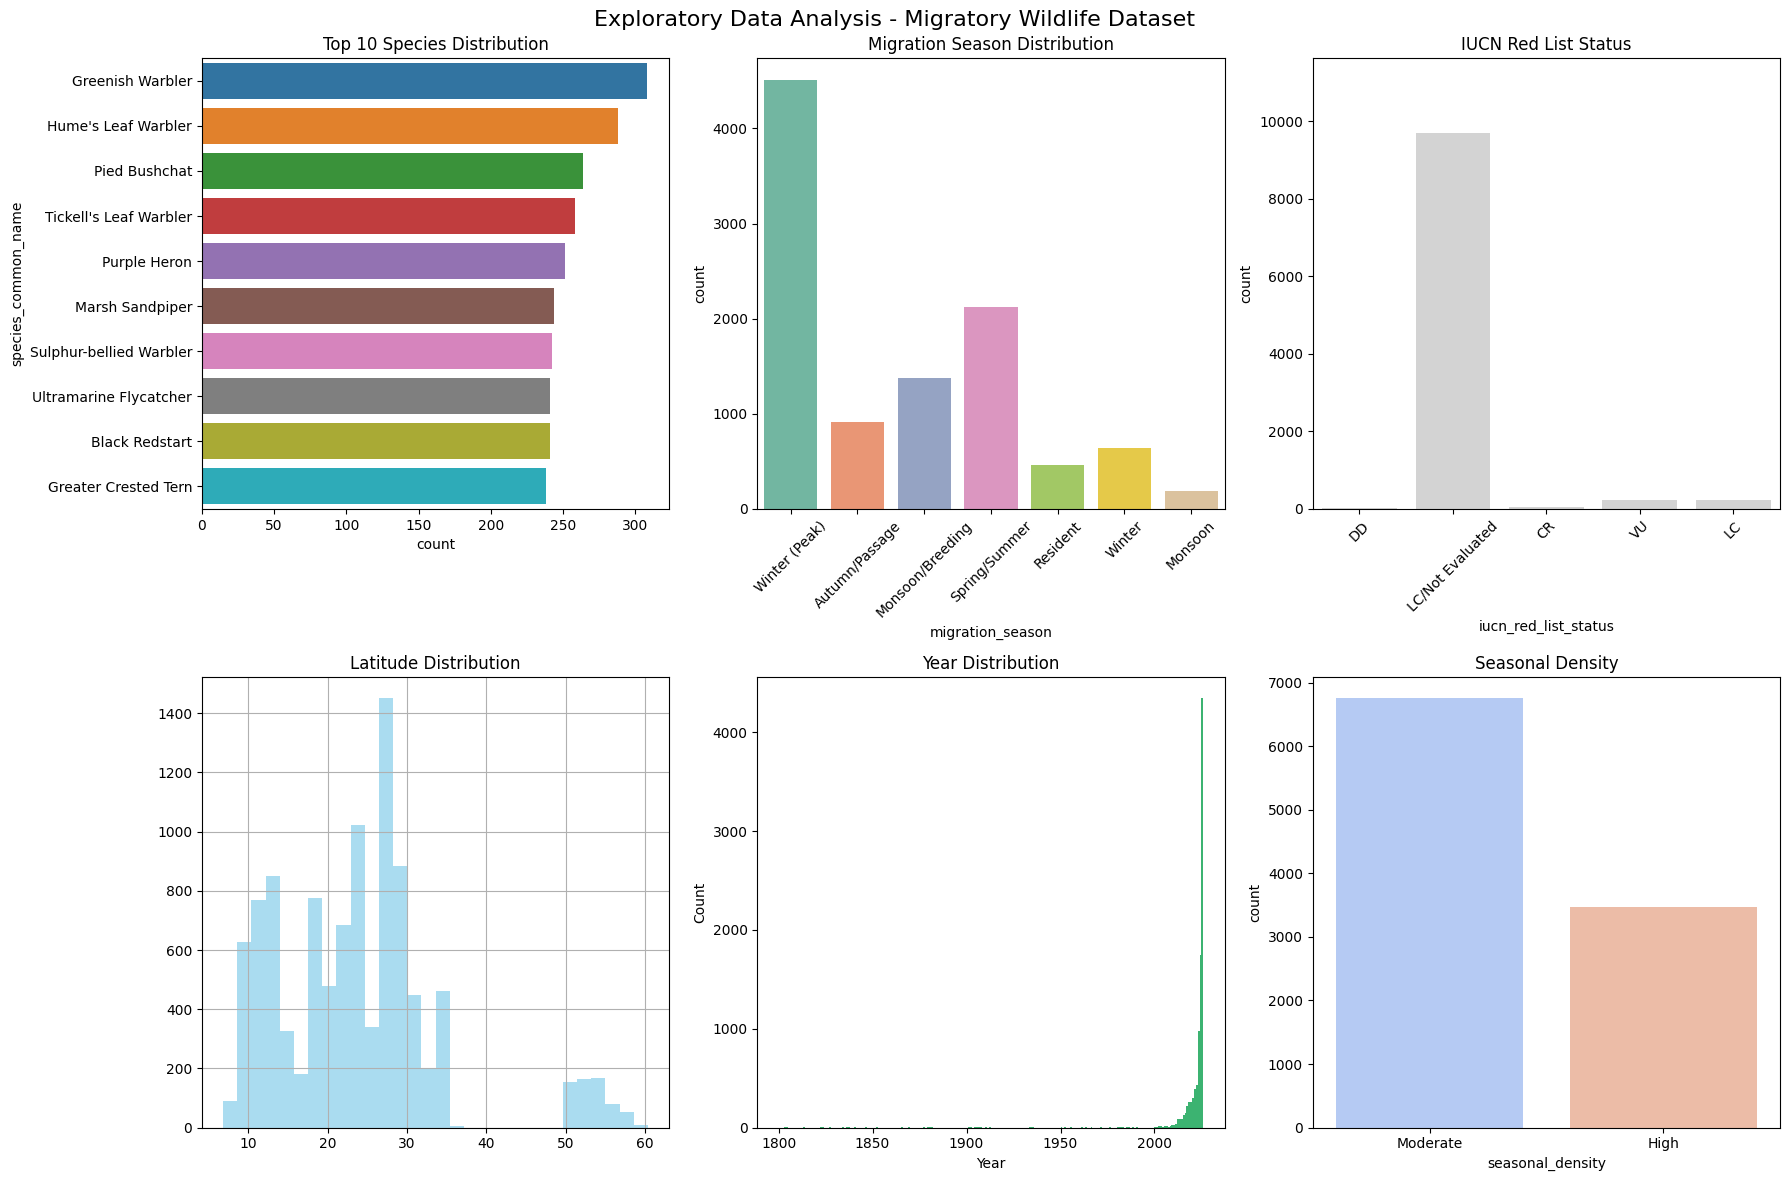

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

iucn_colors = {
    'Least Concern': '#2ca02c',
    'Near Threatened': '#ffeb3b',
    'Vulnerable': '#ff9800',
    'Endangered': '#f44336',
    'Critically Endangered': '#8b0000',
    'Data Deficient': '#9e9e9e',
    'Extinct': '#000000'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis - Migratory Wildlife Dataset', fontsize=16)

species_counts = df['species_common_name'].value_counts().head(10)
sns.countplot(y='species_common_name',
              data=df[df['species_common_name'].isin(species_counts.index)],
              ax=axes[0,0],
              order=species_counts.index,
              palette='tab10')
axes[0,0].set_title('Top 10 Species Distribution')

sns.countplot(data=df, x='migration_season', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Migration Season Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

sns.countplot(data=df,
              x='iucn_red_list_status',
              ax=axes[0,2],
              palette=[iucn_colors.get(status, '#d3d3d3') for status in df['iucn_red_list_status'].unique()])
axes[0,2].set_title('IUCN Red List Status')
axes[0,2].tick_params(axis='x', rotation=45)

max_count = df['iucn_red_list_status'].value_counts().max()
axes[0,2].set_ylim(0, max_count + max_count*0.2)

df['latitude'].hist(bins=30, ax=axes[1,0], alpha=0.7, color='skyblue')
axes[1,0].set_title('Latitude Distribution')

axes[1,1].hist(df['year'], bins=226, range=(1800, 2026), alpha=1, color='mediumseagreen')
axes[1,1].set_title('Year Distribution')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Count')

sns.countplot(data=df, x='seasonal_density', ax=axes[1,2], palette='coolwarm')
axes[1,2].set_title('Seasonal Density')

plt.tight_layout()
plt.show()


In [8]:

features = ['taxonomic_group', 'latitude', 'longitude', 'year', 'month',
           'seasonal_density', 'iucn_red_list_status', 'location_type']
target = 'migration_season'

X_cat = df[features].select_dtypes(include=['object']).columns
X_num = df[features].select_dtypes(include=[np.number]).columns

print("Categorical features:", list(X_cat))
print("Numeric features:", list(X_num))
print(f"Target distribution:\n{df[target].value_counts()}")

Categorical features: ['taxonomic_group', 'seasonal_density', 'iucn_red_list_status', 'location_type']
Numeric features: ['latitude', 'longitude', 'year', 'month']
Target distribution:
migration_season
Winter (Peak)       4511
Spring/Summer       2123
Monsoon/Breeding    1378
Autumn/Passage       918
Winter               644
Resident             457
Monsoon              191
Name: count, dtype: int64


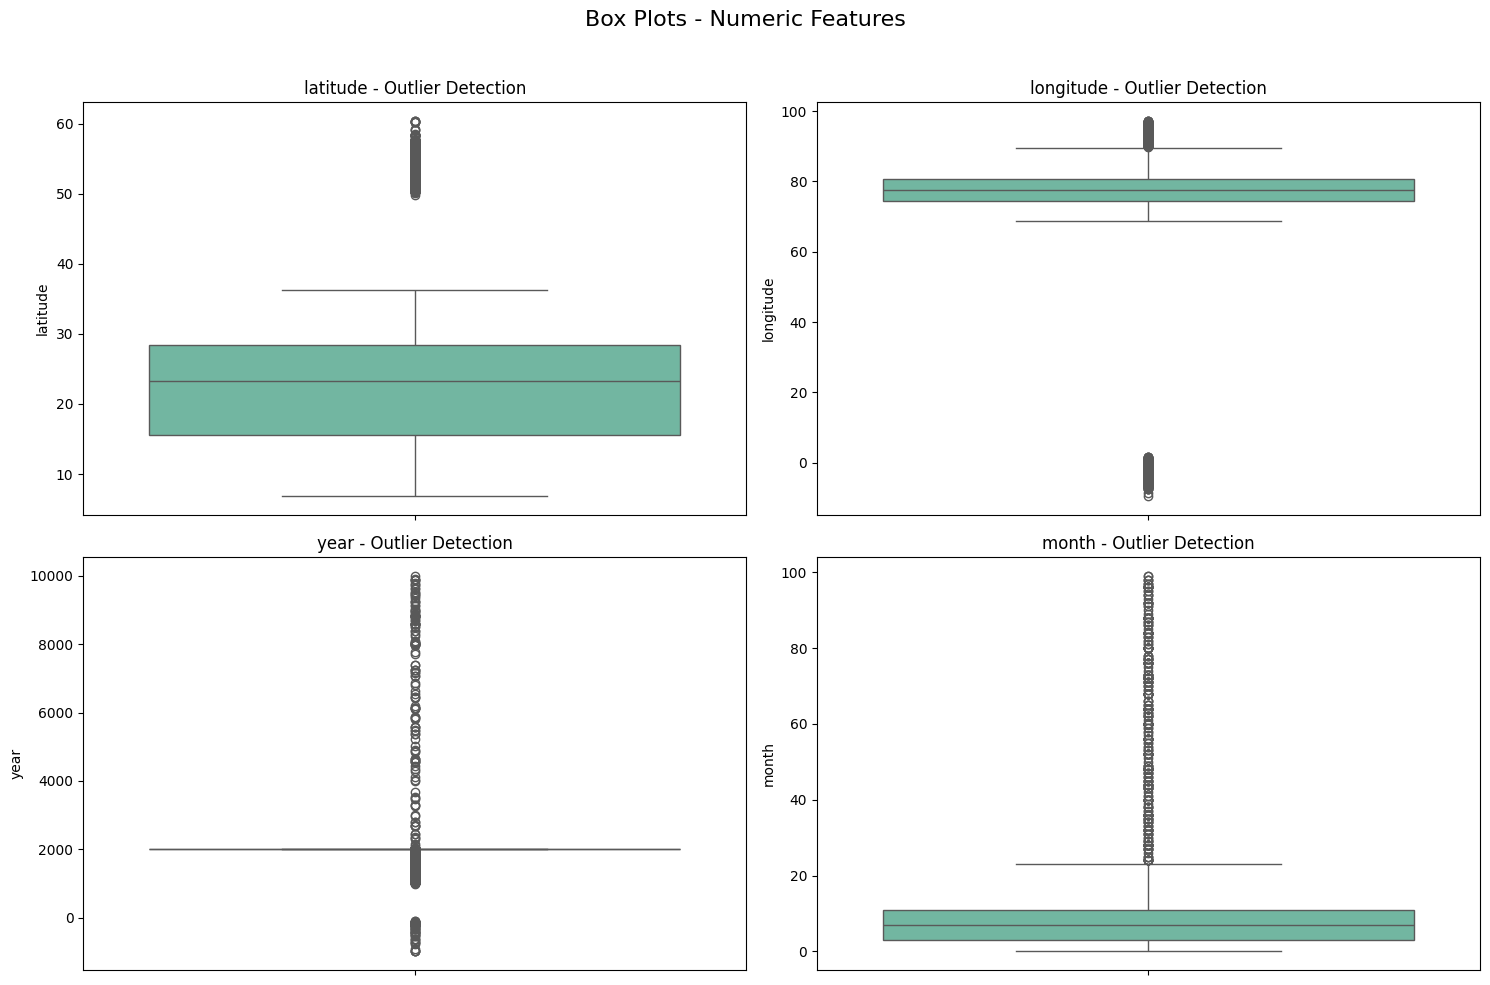

Shape after outlier removal: (8487, 20)


In [9]:
numeric_cols = ['latitude', 'longitude', 'year', 'month']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Box Plots - Numeric Features', fontsize=16)

for i, col in enumerate(numeric_cols):
    row = i // 2
    col_idx = i % 2
    sns.boxplot(data=df, y=col, ax=axes[row, col_idx], palette="Set2")
    axes[row, col_idx].set_title(f'{col} - Outlier Detection')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = df.copy()
for col in ['latitude', 'longitude']:
    df_clean = remove_outliers(df_clean, col)

print(f"Shape after outlier removal: {df_clean.shape}")


In [10]:
# Encode categorical variables
le = LabelEncoder()
X = df_clean[features].copy()

for col in X_cat:
    X[col] = le.fit_transform(X[col].astype(str))

y = le.fit_transform(df_clean[target])

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Target classes:", le.classes_)

Features shape: (8487, 8)
Target shape: (8487,)
Target classes: ['Autumn/Passage' 'Monsoon' 'Monsoon/Breeding' 'Resident' 'Spring/Summer'
 'Winter' 'Winter (Peak)']


In [11]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns for scaling:", num_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Scaling completed successfully!")

Numeric columns for scaling: ['taxonomic_group', 'latitude', 'longitude', 'year', 'month', 'seasonal_density', 'iucn_red_list_status', 'location_type']
Training set: (6789, 8)
Test set: (1698, 8)
Scaling completed successfully!


In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {knn_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

KNN Accuracy: 0.8981

Classification Report:
                  precision    recall  f1-score   support

  Autumn/Passage       0.87      0.93      0.90       176
         Monsoon       0.52      0.48      0.50        27
Monsoon/Breeding       0.92      0.92      0.92       264
        Resident       1.00      0.83      0.91         6
   Spring/Summer       0.96      0.98      0.97       337
          Winter       0.46      0.28      0.35        85
   Winter (Peak)       0.91      0.93      0.92       803

        accuracy                           0.90      1698
       macro avg       0.81      0.77      0.78      1698
    weighted avg       0.89      0.90      0.89      1698



In [13]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_acc:.4f}")

Naive Bayes Accuracy: 0.7220


In [14]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.4f}")

SVM Accuracy: 0.9282


In [15]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_acc:.4f}")

Decision Tree Accuracy: 0.9311


In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

Random Forest Accuracy: 0.9382


In [17]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

Logistic Regression Accuracy: 0.5342


Model Comparison:
                 Model  Accuracy
4        Random Forest  0.938163
3        Decision Tree  0.931095
2                  SVM  0.928151
0                  KNN  0.898115
1          Naive Bayes  0.722026
5  Logistic Regression  0.534158


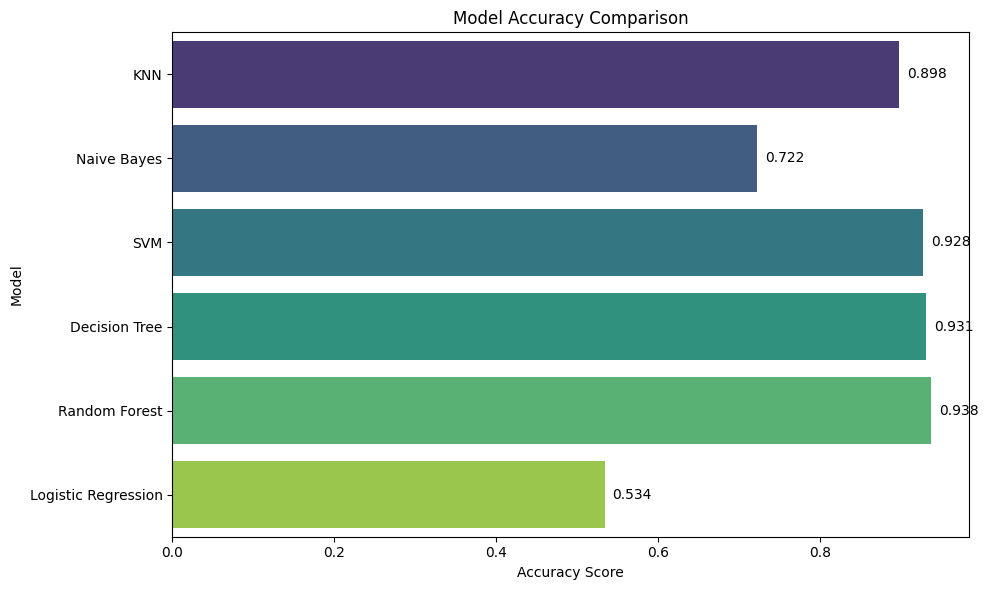

In [18]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [knn_acc, nb_acc, svm_acc, dt_acc, rf_acc, lr_acc]
})

print("Model Comparison:")
print(results.sort_values('Accuracy', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy Score')
for i, v in enumerate(results['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [20]:
df_clean['event_date'] = pd.to_datetime(df_clean['event_date'], errors='coerce')

print(df_clean['event_date'].isna().sum())

df_clean['timestamp'] = df_clean['event_date'].astype(int) / 10**9

X = df_clean[['latitude', 'longitude', 'timestamp']].copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)
df_clean['cluster'] = clusters
print(df_clean['cluster'].value_counts())


8470
cluster
 0    8456
-1      19
 1      12
Name: count, dtype: int64


In [21]:
clusters = df_clean[df_clean['cluster'] != -1]

stopover_sites = clusters.groupby('cluster')[['latitude', 'longitude']].mean().reset_index()
stopover_sites

,cluster,latitude,longitude
0,0,21.390713,77.813917
1,1,15.000000,90.000000


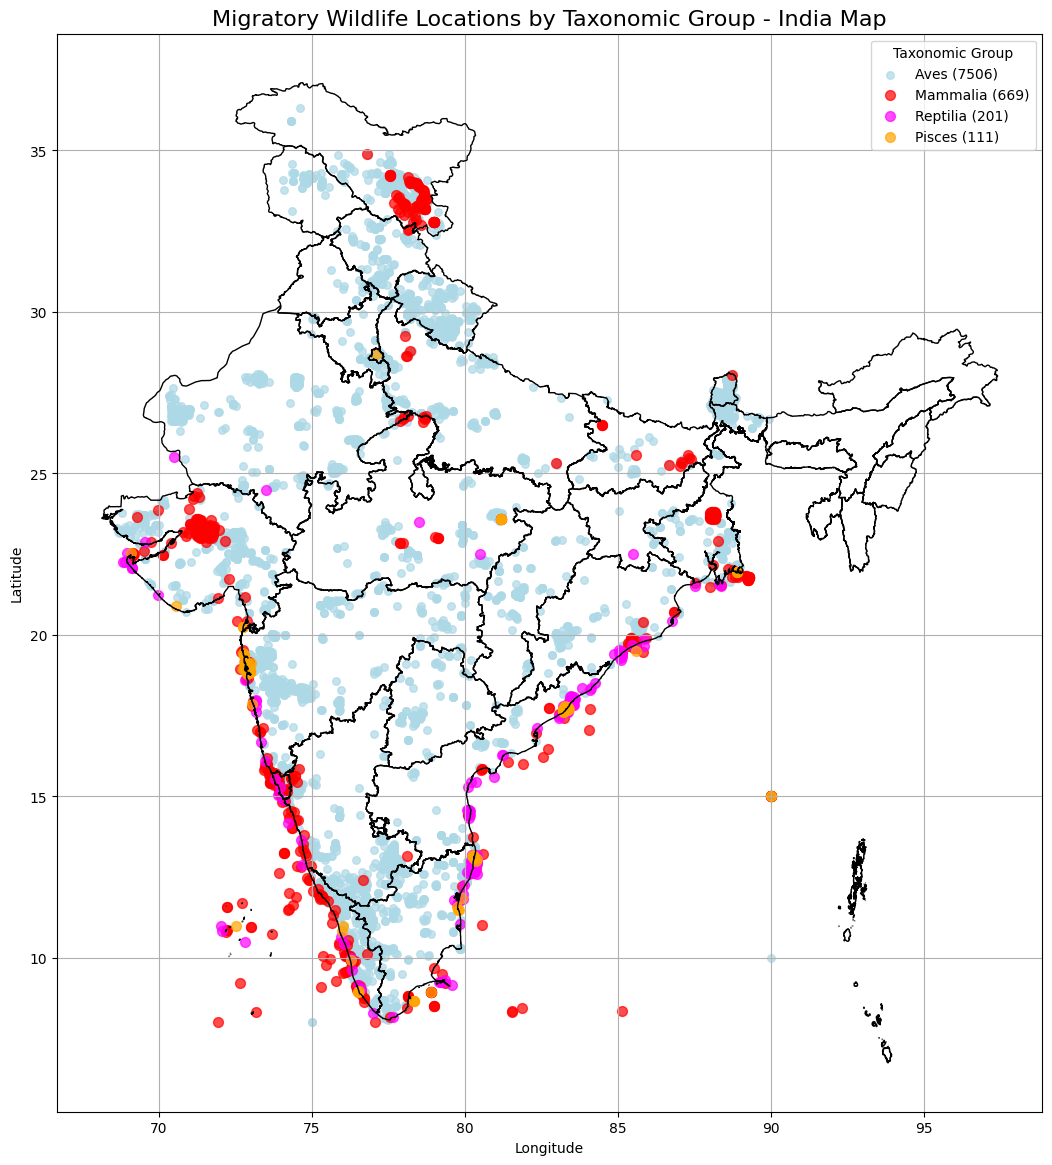

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

india_map = gpd.read_file("/content/drive/MyDrive/VAYU - M /India_State_Boundary/India_State_Boundary.shp")
india_map = india_map.to_crs(epsg=4326)

gdf = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['longitude'], df_clean['latitude']),
    crs="EPSG:4326"
)

colors = {
    'Aves': 'lightblue',
    'Mammalia': 'red',
    'Reptilia': 'magenta',
    'Pisces': 'orange',
    'Amphibia': 'green',
    'Insecta': 'yellow'
}

fig, ax = plt.subplots(figsize=(14, 14))
india_map.boundary.plot(ax=ax, linewidth=1, color='black')

for group, color in colors.items():
    subset = gdf[gdf['taxonomic_group'] == group]
    if len(subset) > 0:
        subset.plot(
            ax=ax,
            markersize=50 if group != 'Aves' else 30,
            color=color,
            label=f"{group} ({len(subset)})",
            alpha=0.7
        )

plt.title("Migratory Wildlife Locations by Taxonomic Group - India Map", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Taxonomic Group', loc='upper right')
plt.grid(True)
plt.show()


In [23]:
plt.savefig('my_map.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [24]:

cluster_counts = df_clean['cluster'].value_counts()
print(cluster_counts)

stopover_clusters = cluster_counts[cluster_counts.index != -1].index

stopover_sites = df_clean[df_clean['cluster'].isin(stopover_clusters)]

print(f"Number of identified stopover clusters: {len(stopover_clusters)}")
print("Example stopover cluster summary:")
print(stopover_sites.groupby('cluster')[['latitude','longitude']].mean())

cluster
 0    8456
-1      19
 1      12
Name: count, dtype: int64
Number of identified stopover clusters: 2
Example stopover cluster summary:
          latitude  longitude
cluster                      
0        21.390713  77.813917
1        15.000000  90.000000


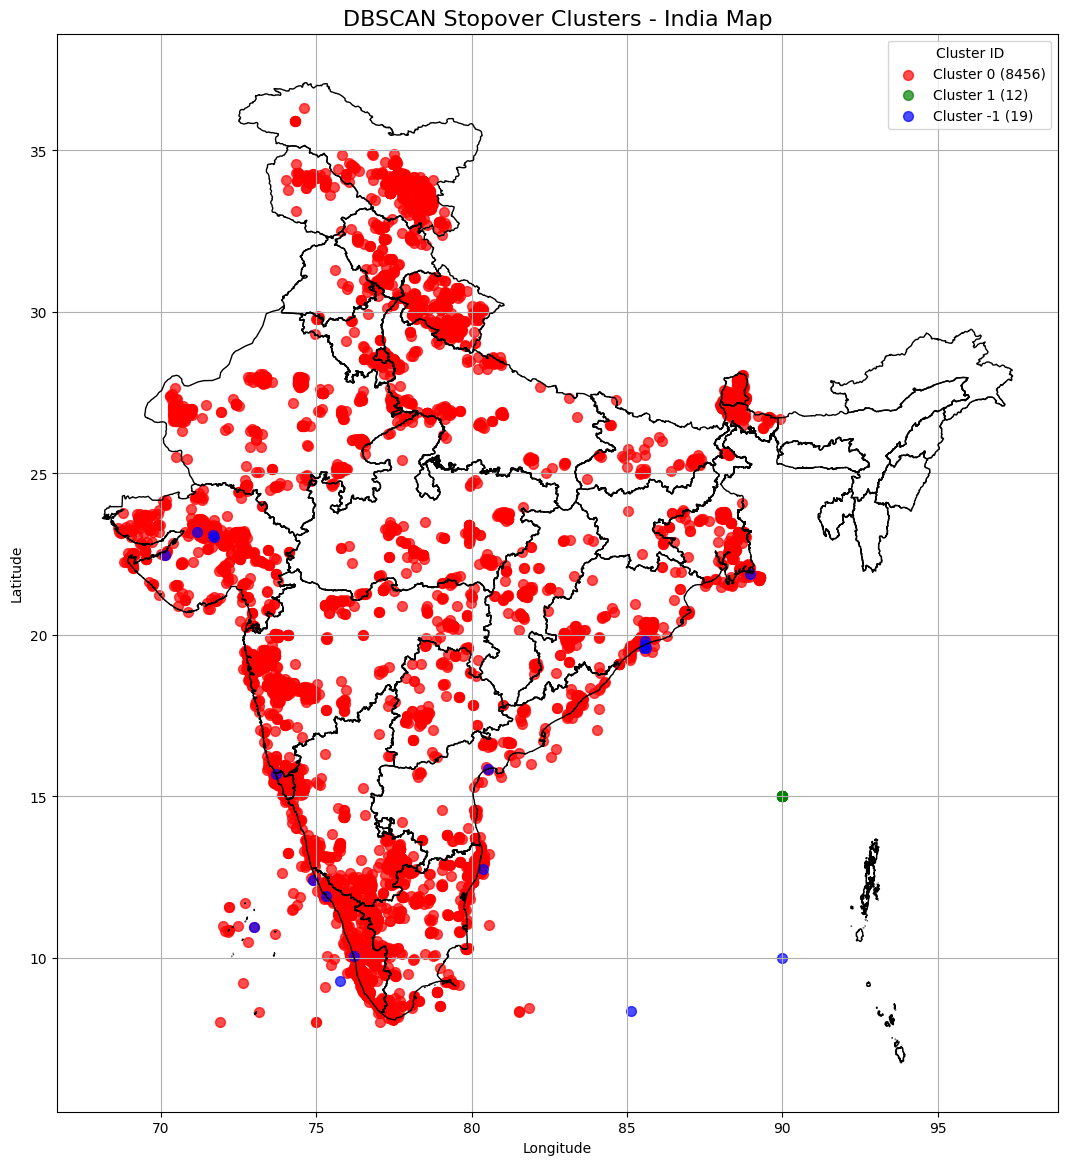

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

india_map = gpd.read_file("/content/drive/MyDrive/VAYU - M /India_State_Boundary/India_State_Boundary.shp")
india_map = india_map.to_crs(epsg=4326)

stopover_gdf = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean['longitude'], df_clean['latitude']),
    crs="EPSG:4326"
)

cluster_colors = {
    0: 'red',
    1: 'green',
    -1: 'blue'
}

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
india_map.boundary.plot(ax=ax, linewidth=1, color='black')

for cluster_id, color in cluster_colors.items():
    subset = stopover_gdf[stopover_gdf['cluster'] == cluster_id]
    if len(subset) > 0:
        subset.plot(
            ax=ax,
            markersize=50,
            color=color,
            label=f"Cluster {cluster_id} ({len(subset)})",
            alpha=0.7
        )

plt.title("DBSCAN Stopover Clusters - India Map", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Cluster ID', loc='upper right')
plt.grid(True)
plt.show()

In [33]:
plt.savefig('my_map_2.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [26]:
stopover_clusters = df_clean[df_clean['cluster'] != -1]

cluster_summary = stopover_clusters.groupby('cluster').agg({
    'latitude': ['mean', 'min', 'max'],
    'longitude': ['mean', 'min', 'max'],
    'species_common_name': 'nunique',
    'event_date': ['min', 'max', 'count']
}).reset_index()

cluster_summary.columns = ['_'.join(col).strip('_') for col in cluster_summary.columns.values]

print("Stopover Cluster Summary:")
display(cluster_summary)


Stopover Cluster Summary:


,cluster,latitude_mean,latitude_min,latitude_max,longitude_mean,longitude_min,longitude_max,species_common_name_nunique,event_date_min,event_date_max,event_date_count
0,0,21.390713,8.0,36.3085,77.813917,68.616489,89.926042,97,NaT,NaT,0
1,1,15.000000,15.0,15.0000,90.000000,90.000000,90.000000,7,NaT,NaT,0


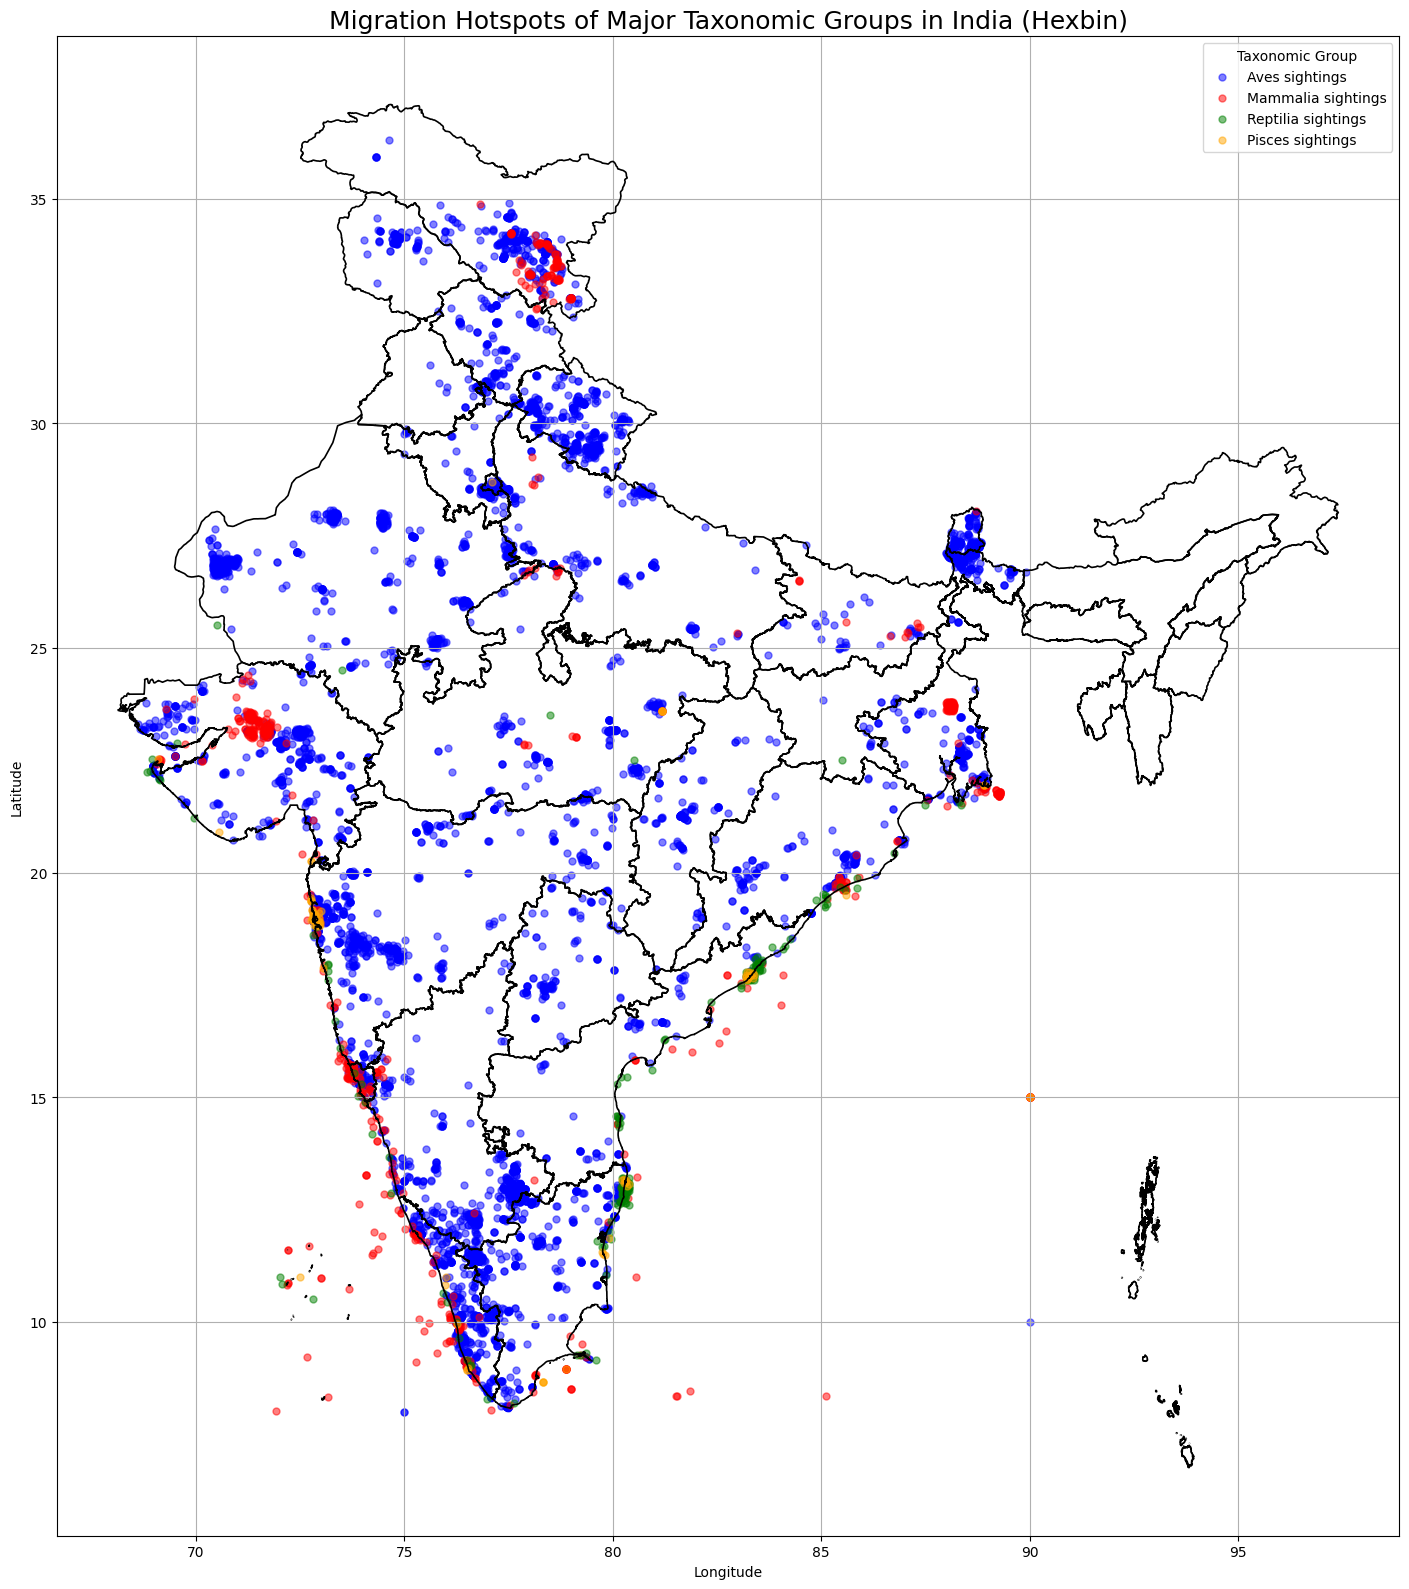

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

india_map = gpd.read_file("/content/drive/MyDrive/VAYU - M /India_State_Boundary/India_State_Boundary.shp").to_crs(epsg=4326)


taxonomic_groups = {
    'Aves': 'blue',
    'Mammalia': 'red',
    'Reptilia': 'green',
    'Pisces': 'orange'
}

fig, ax = plt.subplots(figsize=(16, 16))
india_map.boundary.plot(ax=ax, linewidth=1.2, color='black')

for group, color in taxonomic_groups.items():
    group_data = df_clean[df_clean['taxonomic_group'] == group]

    if group_data.empty:
        print(f" No data for {group}")
        continue


    hb = ax.hexbin(
        group_data['longitude'],
        group_data['latitude'],
        gridsize=20,
        cmap=sns.light_palette(color, as_cmap=True),
        alpha=0.0
    )


    ax.scatter(
        group_data['longitude'],
        group_data['latitude'],
        s=25,
        color=color,
        alpha=0.5,
        label=f"{group} sightings"
    )


ax.set_title("Migration Hotspots of Major Taxonomic Groups in India (Hexbin)", fontsize=18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Taxonomic Group")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
plt.savefig('my_map_3.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

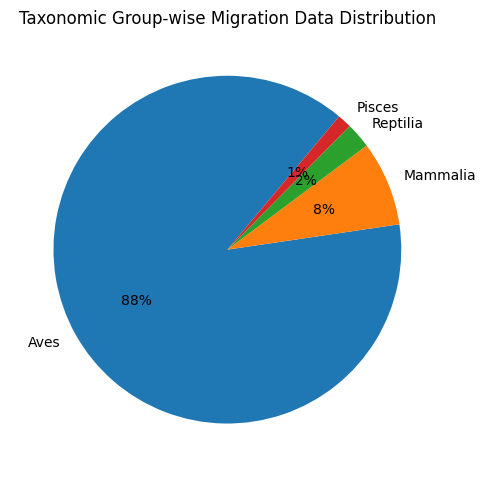

In [28]:
import matplotlib.pyplot as plt

group_col = 'taxonomic_group'  # change if needed

group_counts = df_clean[group_col].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(
    group_counts.values,
    labels=group_counts.index,
    autopct='%1.0f%%',
    startangle=50
)

plt.title("Taxonomic Group-wise Migration Data Distribution")
plt.tight_layout()
plt.show()

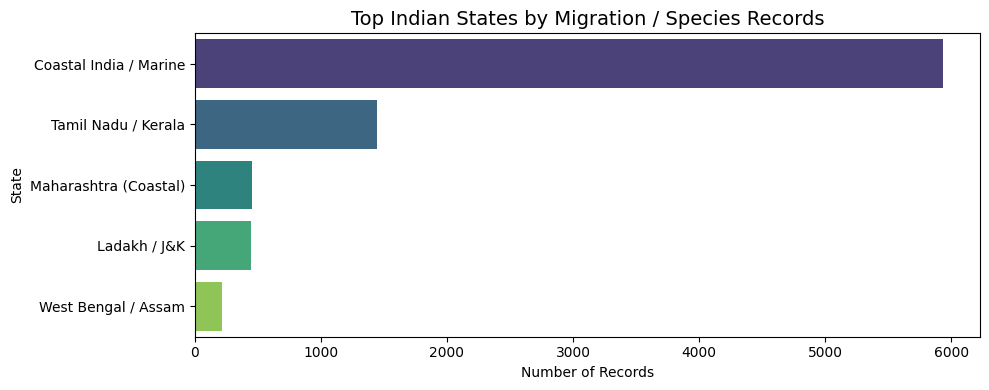

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count records per state
state_counts = df_clean['state_province'].value_counts().head(15)  # top 15 states

plt.figure(figsize=(10, 4))
sns.barplot(
    x=state_counts.values,
    y=state_counts.index,
    palette="viridis"
)

plt.title("Top Indian States by Migration / Species Records", fontsize=14)
plt.xlabel("Number of Records")
plt.ylabel("State")
plt.tight_layout()
plt.show()

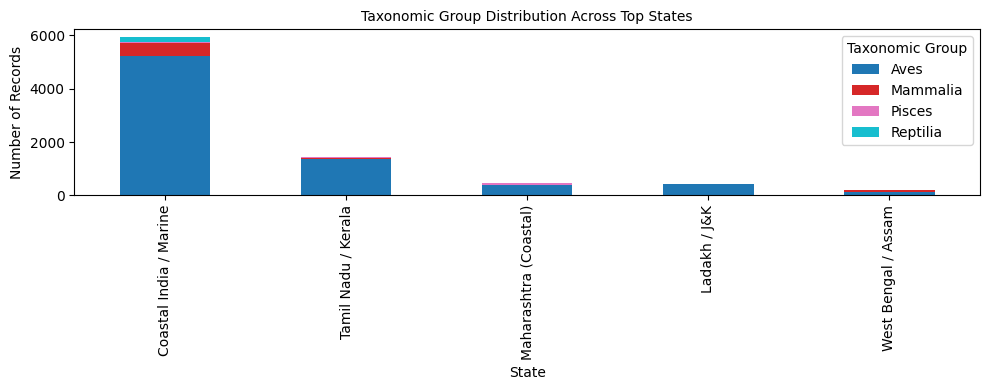

In [30]:
state_group = (
    df_clean
    .groupby(['state_province', 'taxonomic_group'])
    .size()
    .unstack(fill_value=0)
)

# Select top states only (avoid clutter)
top_states = state_group.sum(axis=1).sort_values(ascending=False).head(10).index
state_group = state_group.loc[top_states]

state_group.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 4),
    colormap='tab10'
)

plt.title("Taxonomic Group Distribution Across Top States", fontsize=10)
plt.xlabel("State")
plt.ylabel("Number of Records")
plt.legend(title="Taxonomic Group", bbox_to_anchor=(1.0, 1))
plt.tight_layout()
plt.show()

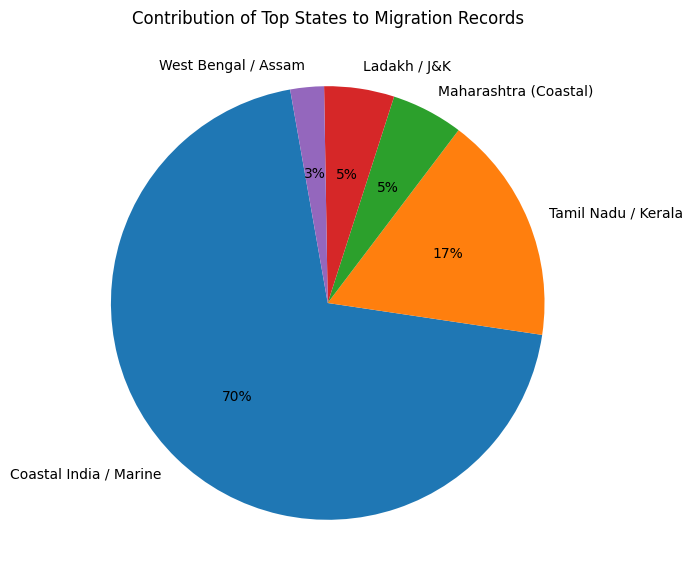

In [31]:
state_counts = df_clean['state_province'].value_counts().head(8)

plt.figure(figsize=(7, 7))
plt.pie(
    state_counts,
    labels=state_counts.index,
    autopct='%1.0f%%',
    startangle=100
)

plt.title("Contribution of Top States to Migration Records")
plt.tight_layout()
plt.show()